In [1]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite.tigramite import plotting as tp
from tigramite.tigramite.pcmci import PCMCI
from tigramite.tigramite.independence_tests import ParCorr
import tigramite.tigramite.data_processing as pp
import seaborn as sns
import scipy.stats as st
import random

Could not import packages for CMIknn and GPDC estimation
Could not import rpy package
Could not import r-package RCIT


In [137]:
#f_sst = Dataset('sst.mnmean.nc')
#f_sst_anomaly = Dataset('sst.mon.ltm.1981-2010.nc')
f_sat = Dataset('pres.mon.mean.nc')

In [138]:
data_sat = f_sat.variables['pres']
lon_sat = f_sat.variables['lon'][:]
lat_sat = f_sat.variables['lat'][:]
time_sat = f_sat.variables['time'][:]
data_sat = np.swapaxes(data_sat,0,2)

# SAT:

In [139]:
result_sat = []
index = []
lat_sat_list = []
lon_sat_list =[]

for i in range(data_sat.shape[0]):
    for j in range(data_sat.shape[1]):
        if not data_sat[i,j,-1]<-9.9e+36:
            result_sat.append(data_sat[i,j,:-43])
            #result_sat.append(data_sat[i,j,:])
            index.append((lon_sat[i],lat_sat[j]))
            lon_sat_list.append(lon_sat[i])
            lat_sat_list.append(lat_sat[j])

In [140]:
result_sat = pf.deseasonalize(np.array(result_sat))
n_components_sat = 10

result_sat = np.matrix(result_sat)
result_sat = result_sat.transpose()
data = pd.DataFrame(result_sat)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components_sat)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_sat = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_sat.idxmax(axis=1)
df_sat = pd.DataFrame({"lons":lon_sat_list,"lats":lat_sat_list,"clusters":clusters.values.tolist()})

lon_temp = df_sat["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sat["lons"].vlues = lon_temp

# SPI:

In [1]:
data_spi = np.load('spi1.npy')
lat_spi = np.load('lat.npy')
lon_spi = np.load('lon.npy')

NameError: name 'np' is not defined

In [2]:
result_spi = []
index = []
lat_spi_list = []
lon_spi_list =[]

for i in range(data_spi.shape[0]):
    for j in range(data_spi.shape[1]):
        if not np.isnan(data_spi[i,j,-1]):
        #if not data_spi[i,j,-1]<0:
            result_spi.append(data_spi[i,j,24:])
            index.append((lon_spi[i],lat_spi[j]))
            lon_spi_list.append(lon_spi[i])
            lat_spi_list.append(lat_spi[j])

NameError: name 'data_spi' is not defined

In [143]:
#result_spi = pf.deseasonalize(np.array(result_spi))
n_components_spi = 6

result_spi = np.matrix(result_spi)
result_spi = result_spi.transpose()
data = pd.DataFrame(result_spi)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components_spi)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_spi = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_spi.idxmax(axis=1)
df_spi = pd.DataFrame({"lons":lon_spi_list,"lats":lat_spi_list,"clusters":clusters.values.tolist()})

lon_temp = df_spi["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_spi["lons"].vlues = lon_temp

In [144]:
sat_name  = []
for i in range(n_components_sat):
    sat_name.append("SAT_%d"%i)

In [145]:
spi_name  = []
for i in range(n_components_spi):
    spi_name.append("SPI_%d"%i)

In [146]:
var_names = spi_name + sat_name

In [147]:
result_spi = result_spi.dot(loading_spi)
result_sat = result_sat.dot(loading_sat)

In [148]:
result = np.concatenate((result_spi, result_sat), axis=1)

In [149]:
result = np.matrix(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [150]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 11 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.256
        (SPI_1 0): pval = 0.00010 | val = -0.137
        (SPI_5 0): pval = 0.00024 | val = -0.130
        (SAT_4 0): pval = 0.00097 | val = -0.117
        (SAT_8 0): pval = 0.00146 | val = 0.113
        (SPI_3 0): pval = 0.00155 | val = 0.112
        (SAT_7 0): pval = 0.01038 | val = -0.091
        (SPI_4 0): pval = 0.01097 | val = -0.090
        (SPI_1 -1): pval = 0.01651 | val = -0.085
        (SAT_6 -2): pval = 0.02635 | val = 0.079
        (SAT_2 0): pval = 0.04058 | val = 0.072

    Variable SPI_1 has 9 link(s):
        (SPI_4 0): pval = 0.00000 | val = -0.477
        (SPI_1 -1): pval = 0.00000 | val = 0.273
        (SPI_3 0): pval = 0.00000 | val = 0.176
        (SPI_2 0): pval = 0.00000 | val = -0.173
        (SPI_5 0): pval = 0.00002 | val = 0.149
        (SPI_0 0): pval = 0.00010 | val = -0.137
        (SAT_6 -1): pval = 0.00028 | val = -0.128
        (SA

In [151]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable SPI_0 has 6 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.256
        (SPI_1 0): pval = 0.00010 | qval = 0.00010 | val = -0.137
        (SPI_5 0): pval = 0.00024 | qval = 0.00024 | val = -0.130
        (SAT_4 0): pval = 0.00097 | qval = 0.00097 | val = -0.117
        (SAT_8 0): pval = 0.00146 | qval = 0.00146 | val = 0.113
        (SPI_3 0): pval = 0.00155 | qval = 0.00155 | val = 0.112

    Variable SPI_1 has 7 link(s):
        (SPI_4 0): pval = 0.00000 | qval = 0.00000 | val = -0.477
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.273
        (SPI_3 0): pval = 0.00000 | qval = 0.00000 | val = 0.176
        (SPI_2 0): pval = 0.00000 | qval = 0.00000 | val = -0.173
        (SPI_5 0): pval = 0.00002 | qval = 0.00002 | val = 0.149
        (SPI_0 0): pval = 0.00010 | qval = 0.00010 | val = -0.137
        (SAT_6 -1): pval = 0.00028 | qval = 0.00421 | val = -0.128

    Variable SPI_2 has 5 link(s):
 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58dbb1e4a8>)

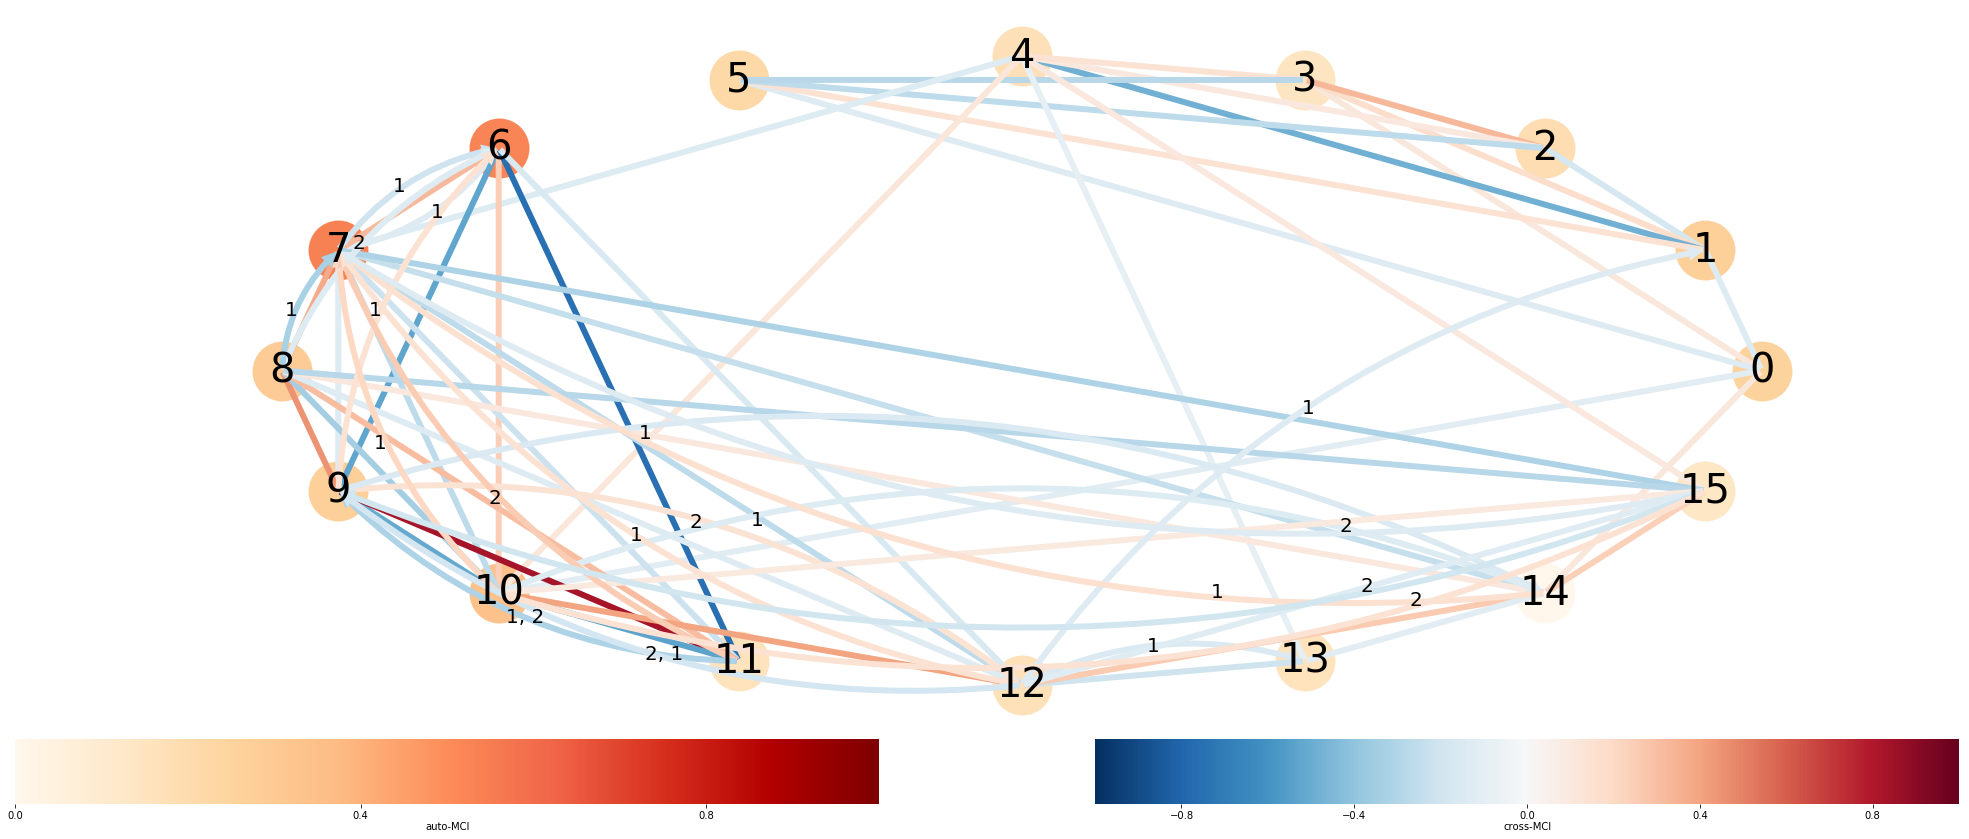

In [152]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

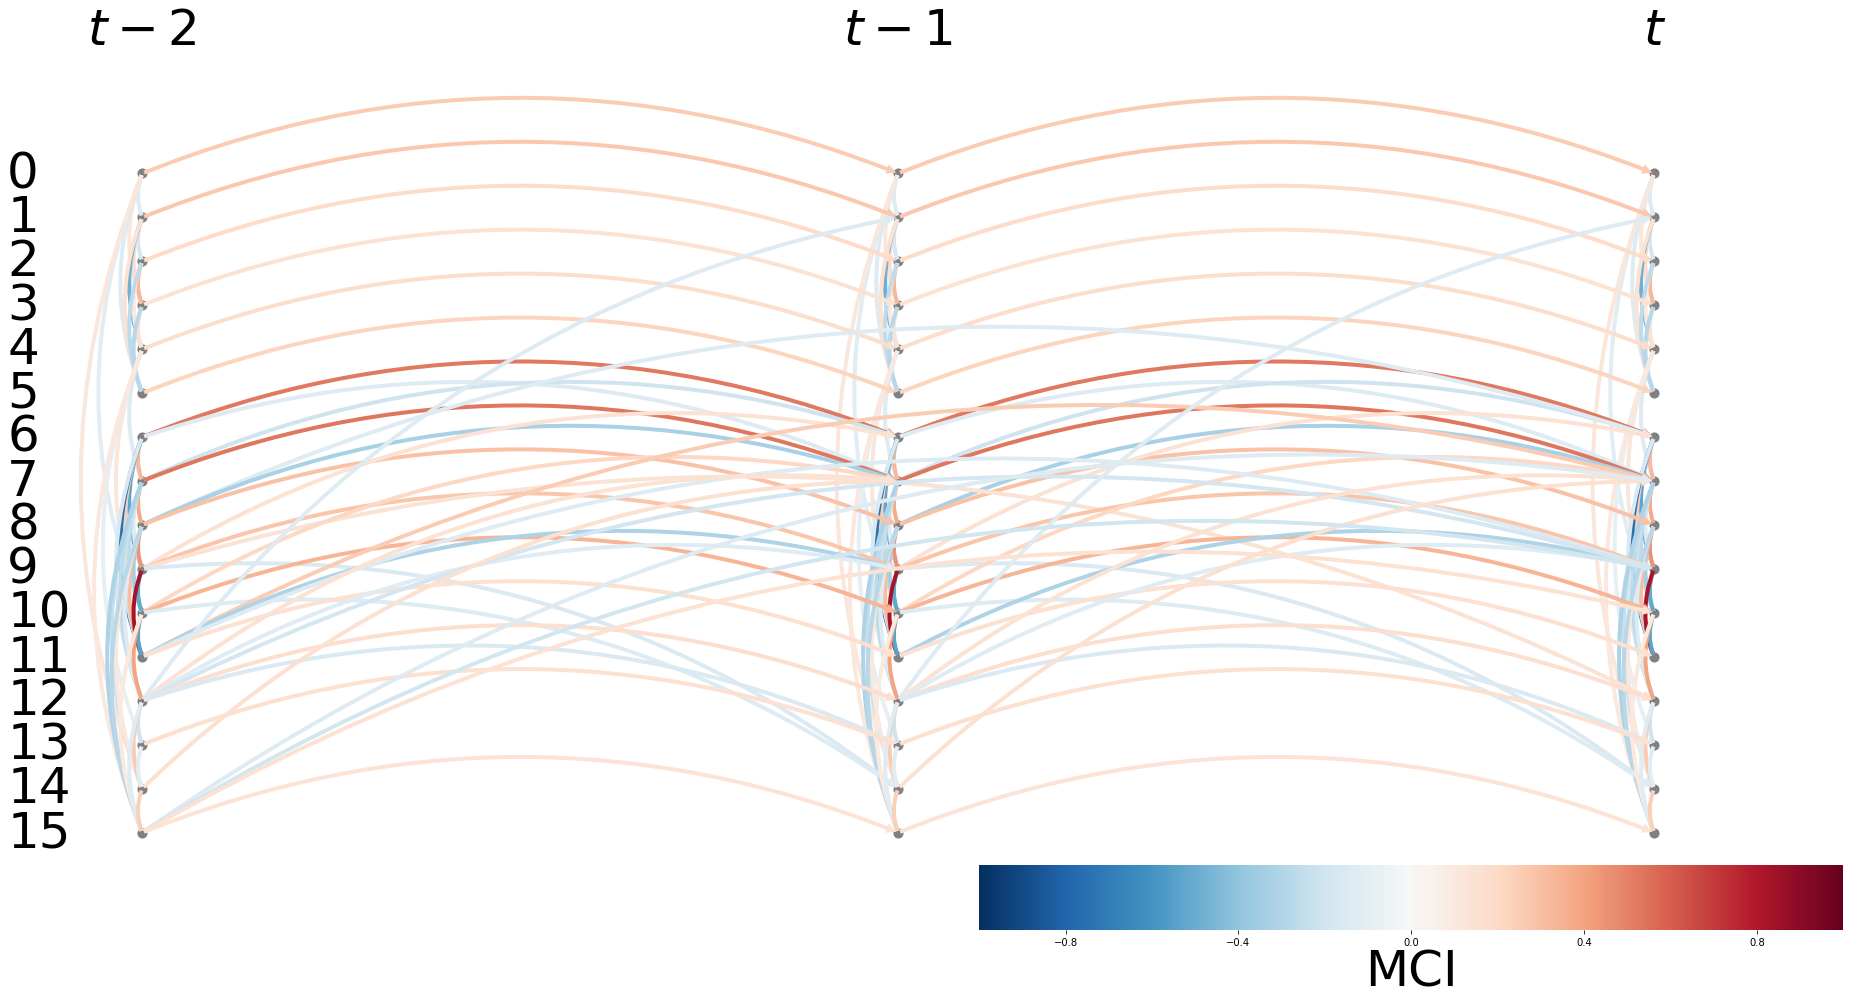

In [153]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

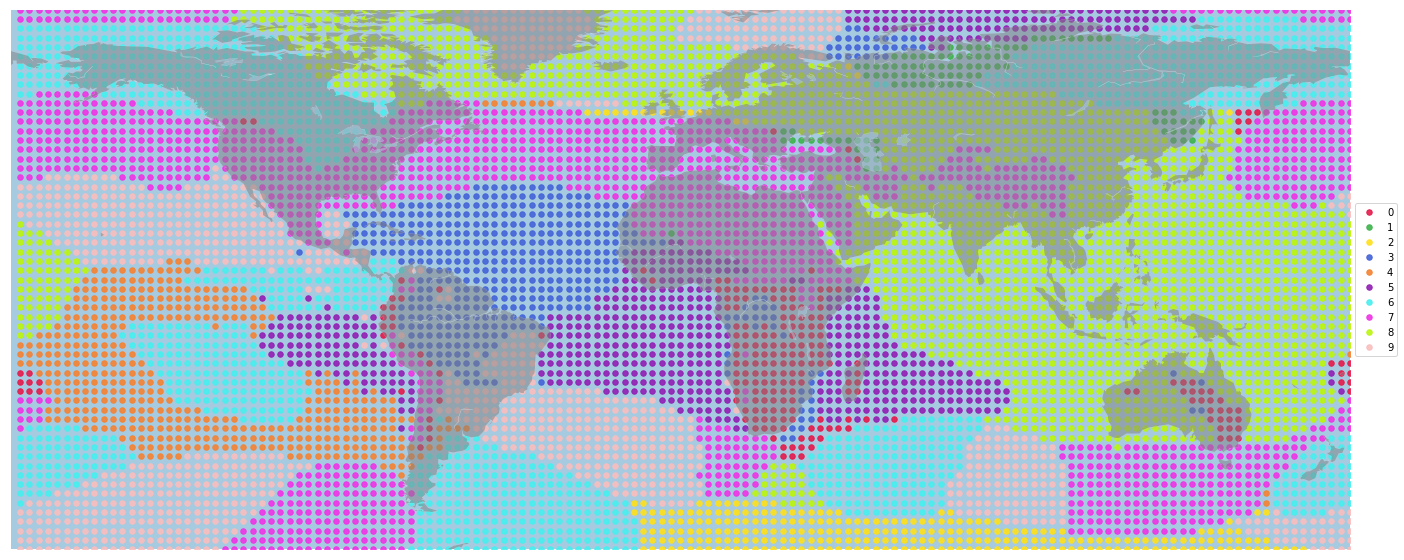

In [154]:
df_list = []
for j in range(n_components_sat):
    df_list.append(pd.DataFrame(columns=df_sat.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


for i in range(n_components_sat):
    values = df_sat["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sat.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

In [28]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=1, color="black")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i, c = colors[i])

    
plt.legend()
plt.show()

NameError: name 'df' is not defined

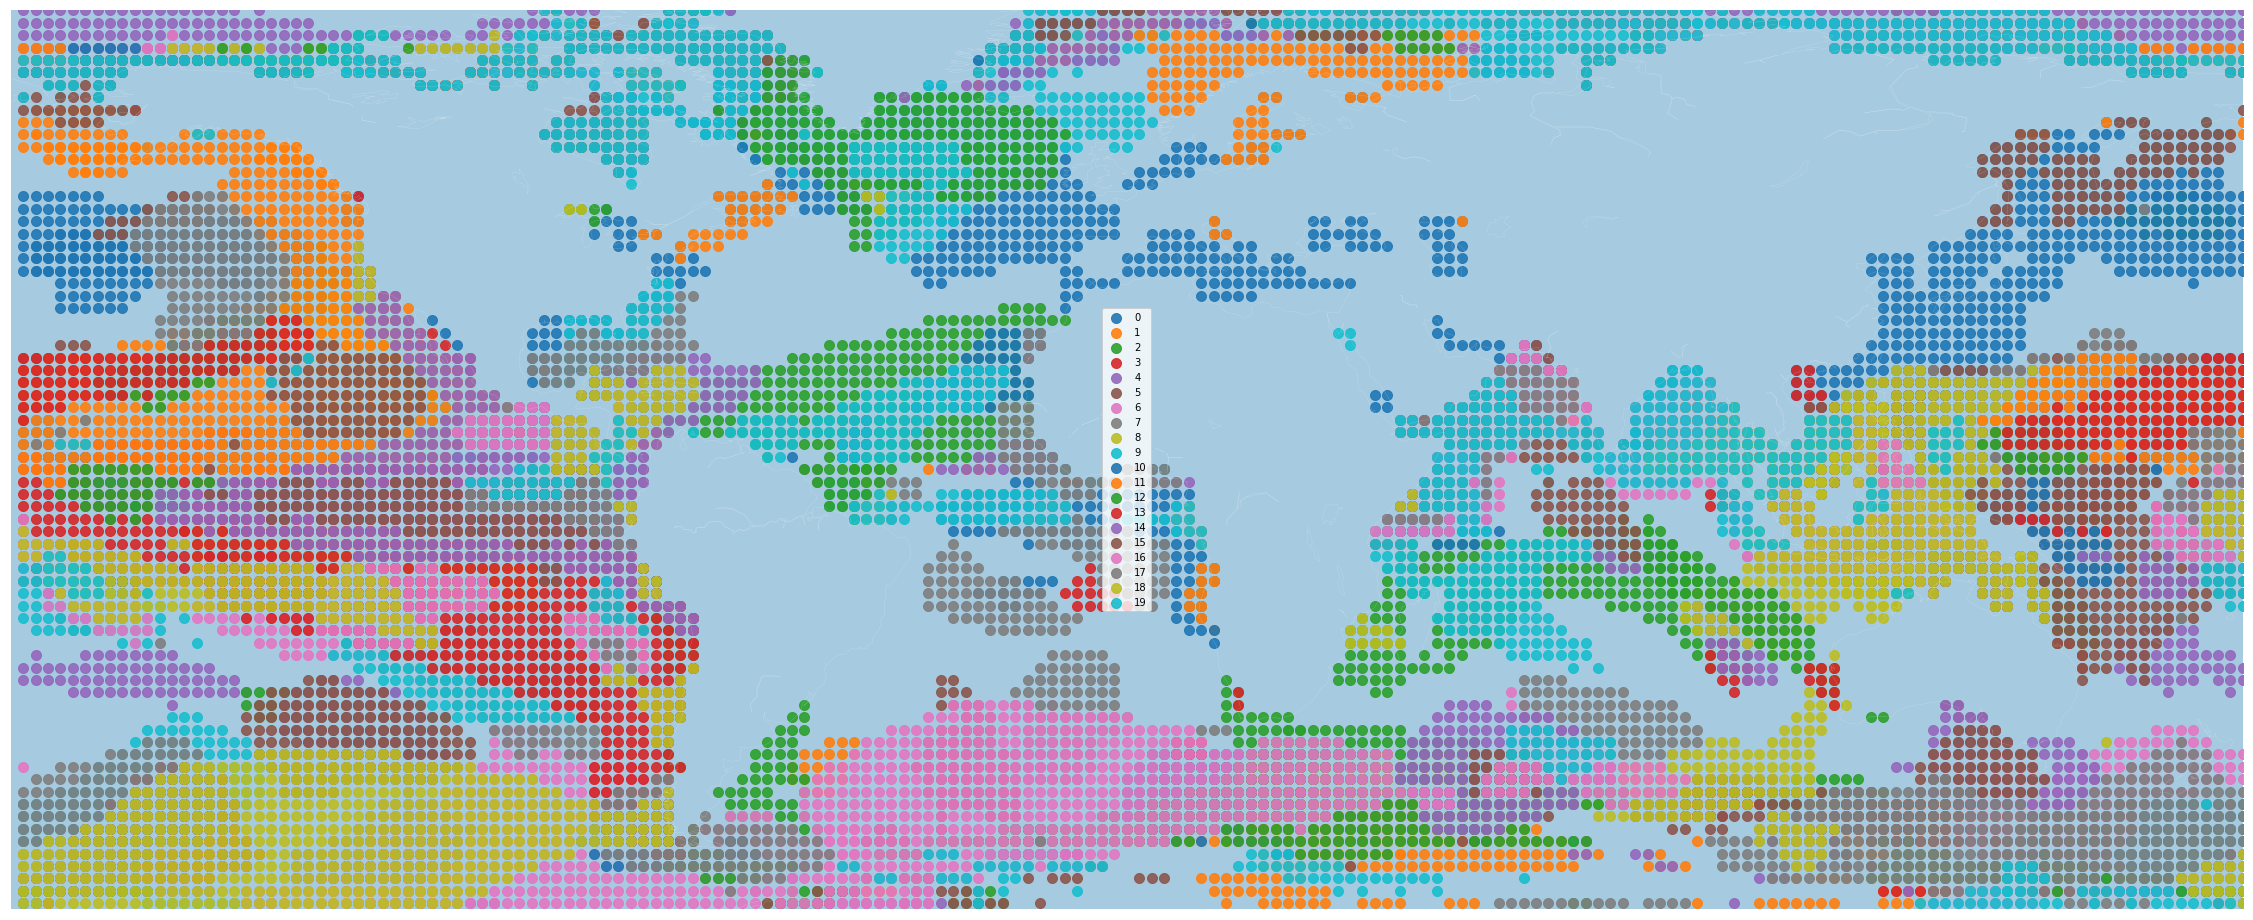

In [32]:
limit = 0.99

df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()
#plt.savefig("world_clusters.png")

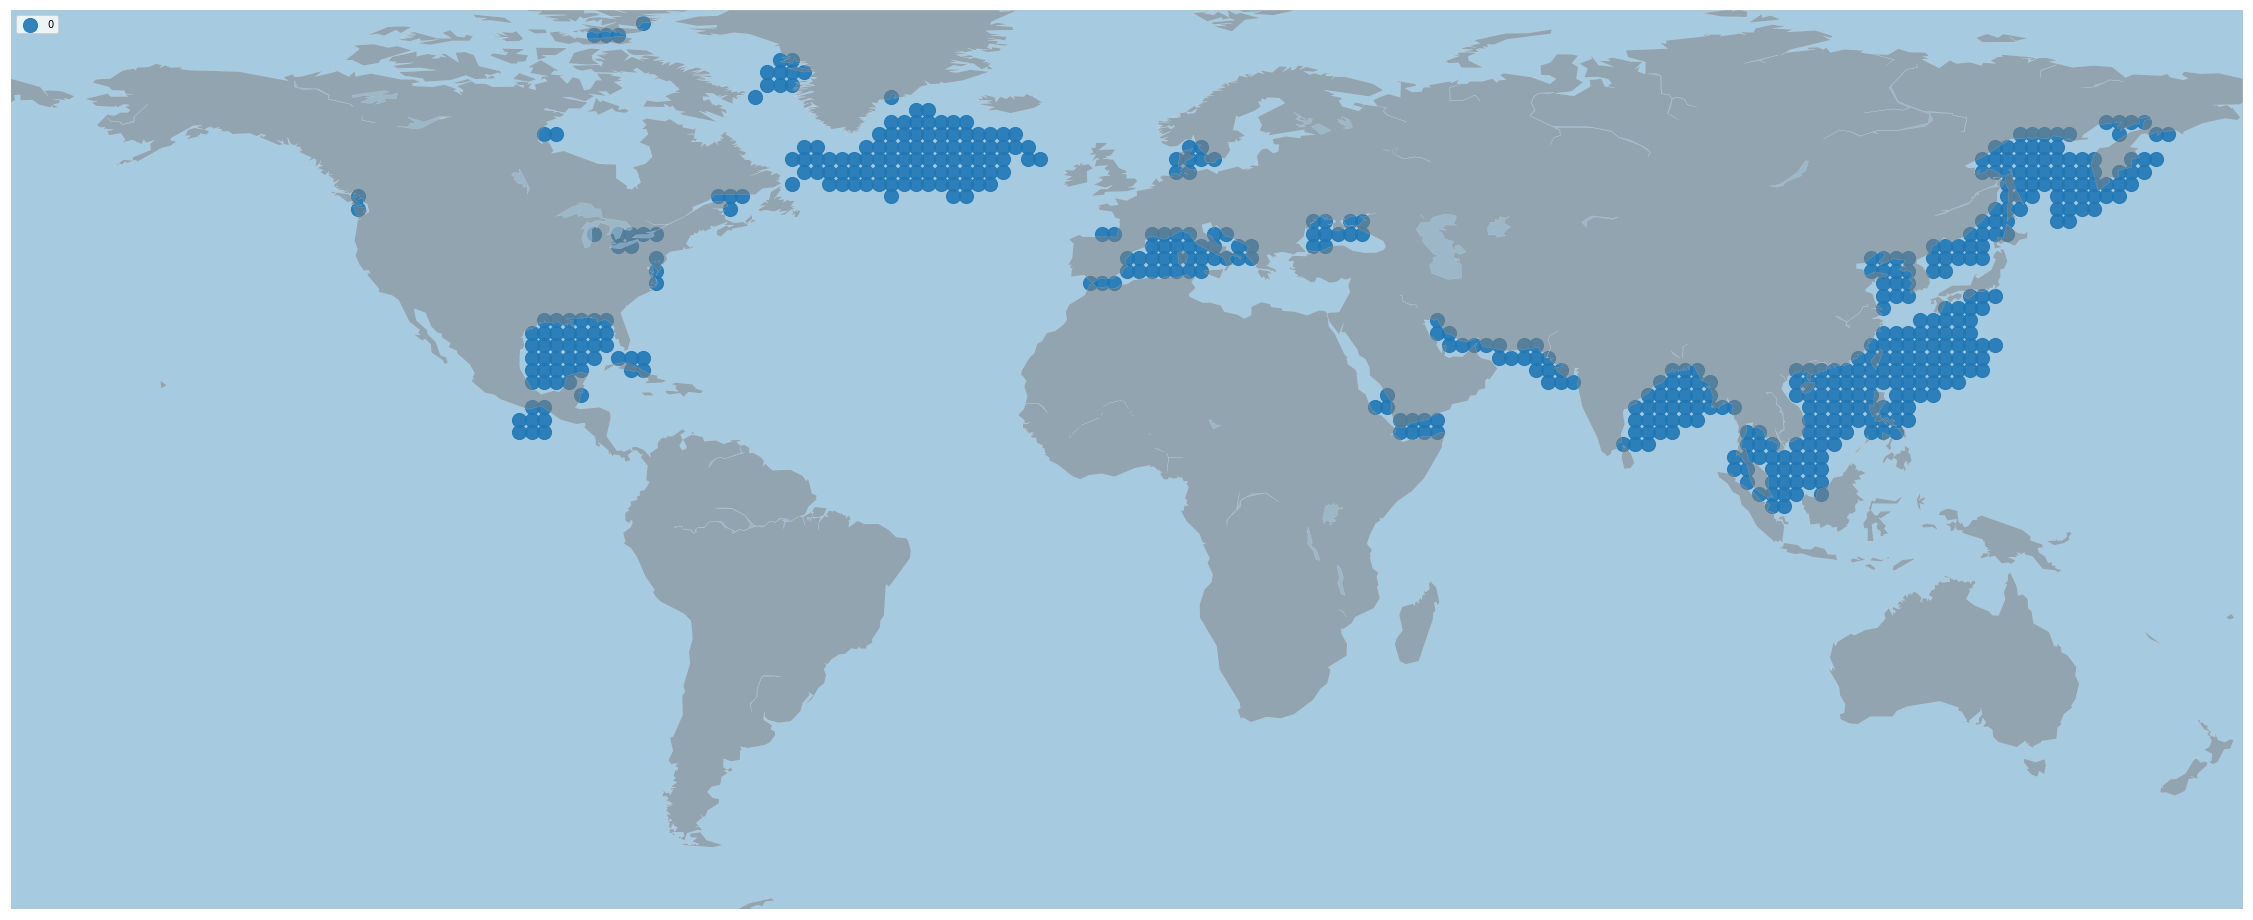

In [33]:
limit = 0.95

i = 0
df1 = pd.DataFrame(columns=df.columns)

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
df1 = df.iloc[Idx,:]
df1["values"] = values

lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [34]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [35]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [36]:
results = pcmci.run_pcmci(tau_max=5, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 54 link(s):
        (0 -1): pval = 0.00000 | val = 0.782
        (9 0): pval = 0.00000 | val = 0.332
        (1 0): pval = 0.00000 | val = 0.271
        (9 -3): pval = 0.00000 | val = 0.159
        (0 -2): pval = 0.00000 | val = -0.154
        (15 0): pval = 0.00000 | val = 0.153
        (13 0): pval = 0.00000 | val = -0.148
        (2 0): pval = 0.00000 | val = 0.144
        (6 0): pval = 0.00000 | val = -0.143
        (16 0): pval = 0.00000 | val = -0.140
        (19 -1): pval = 0.00000 | val = -0.137
        (11 0): pval = 0.00000 | val = -0.132
        (15 -2): pval = 0.00000 | val = -0.127
        (4 -3): pval = 0.00000 | val = 0.115
        (10 -3): pval = 0.00000 | val = 0.112
        (1 -3): pval = 0.00000 | val = -0.107
        (18 0): pval = 0.00001 | val = -0.099
        (4 -4): pval = 0.00007 | val = -0.090
        (1 -2): pval = 0.00008 | val = 0.090
        (7 0): pval = 0.00008 | val = 0.090
        (16 -1): pval

In [37]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 29 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.782
        (9 0): pval = 0.00000 | qval = 0.00000 | val = 0.332
        (1 0): pval = 0.00000 | qval = 0.00000 | val = 0.271
        (9 -3): pval = 0.00000 | qval = 0.00000 | val = 0.159
        (0 -2): pval = 0.00000 | qval = 0.00000 | val = -0.154
        (15 0): pval = 0.00000 | qval = 0.00000 | val = 0.153
        (13 0): pval = 0.00000 | qval = 0.00000 | val = -0.148
        (2 0): pval = 0.00000 | qval = 0.00000 | val = 0.144
        (6 0): pval = 0.00000 | qval = 0.00000 | val = -0.143
        (16 0): pval = 0.00000 | qval = 0.00000 | val = -0.140
        (19 -1): pval = 0.00000 | qval = 0.00000 | val = -0.137
        (11 0): pval = 0.00000 | qval = 0.00000 | val = -0.132
        (15 -2): pval = 0.00000 | qval = 0.00000 | val = -0.127
        (4 -3): pval = 0.00000 | qval = 0.00001 | val = 0.115
        (10 -3): pval = 0.00000 | qval = 0.00002 | val =

In [38]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5b146db668>)

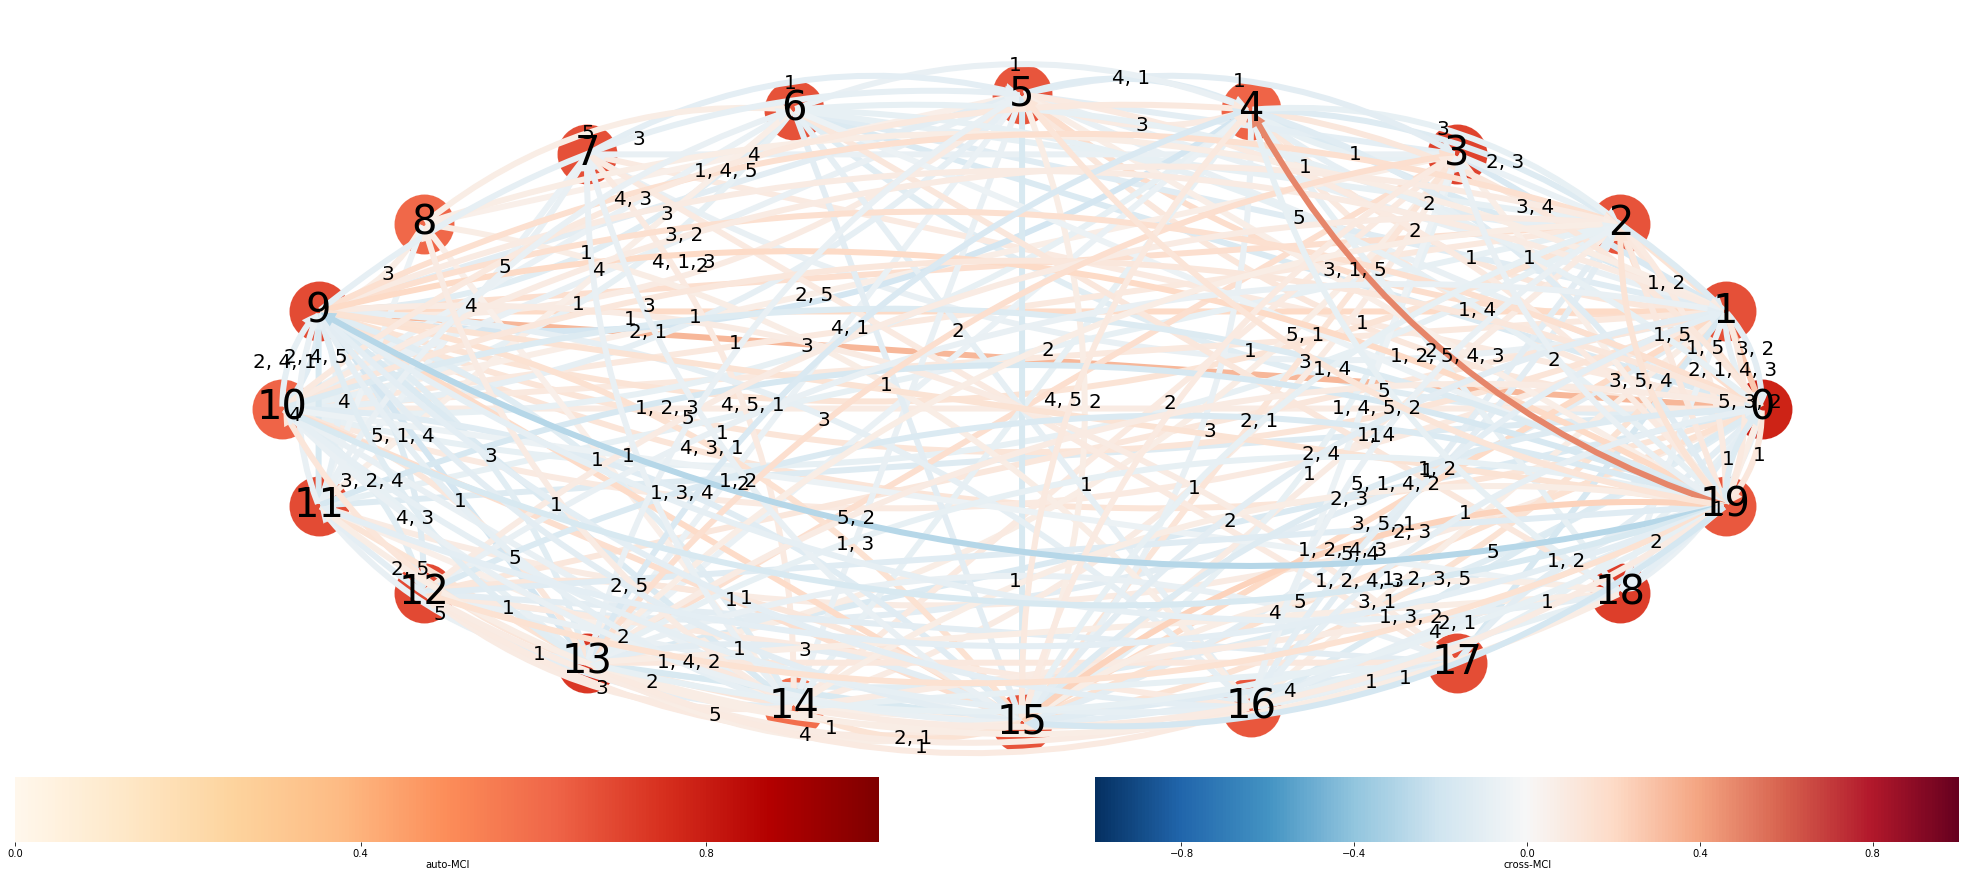

In [39]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

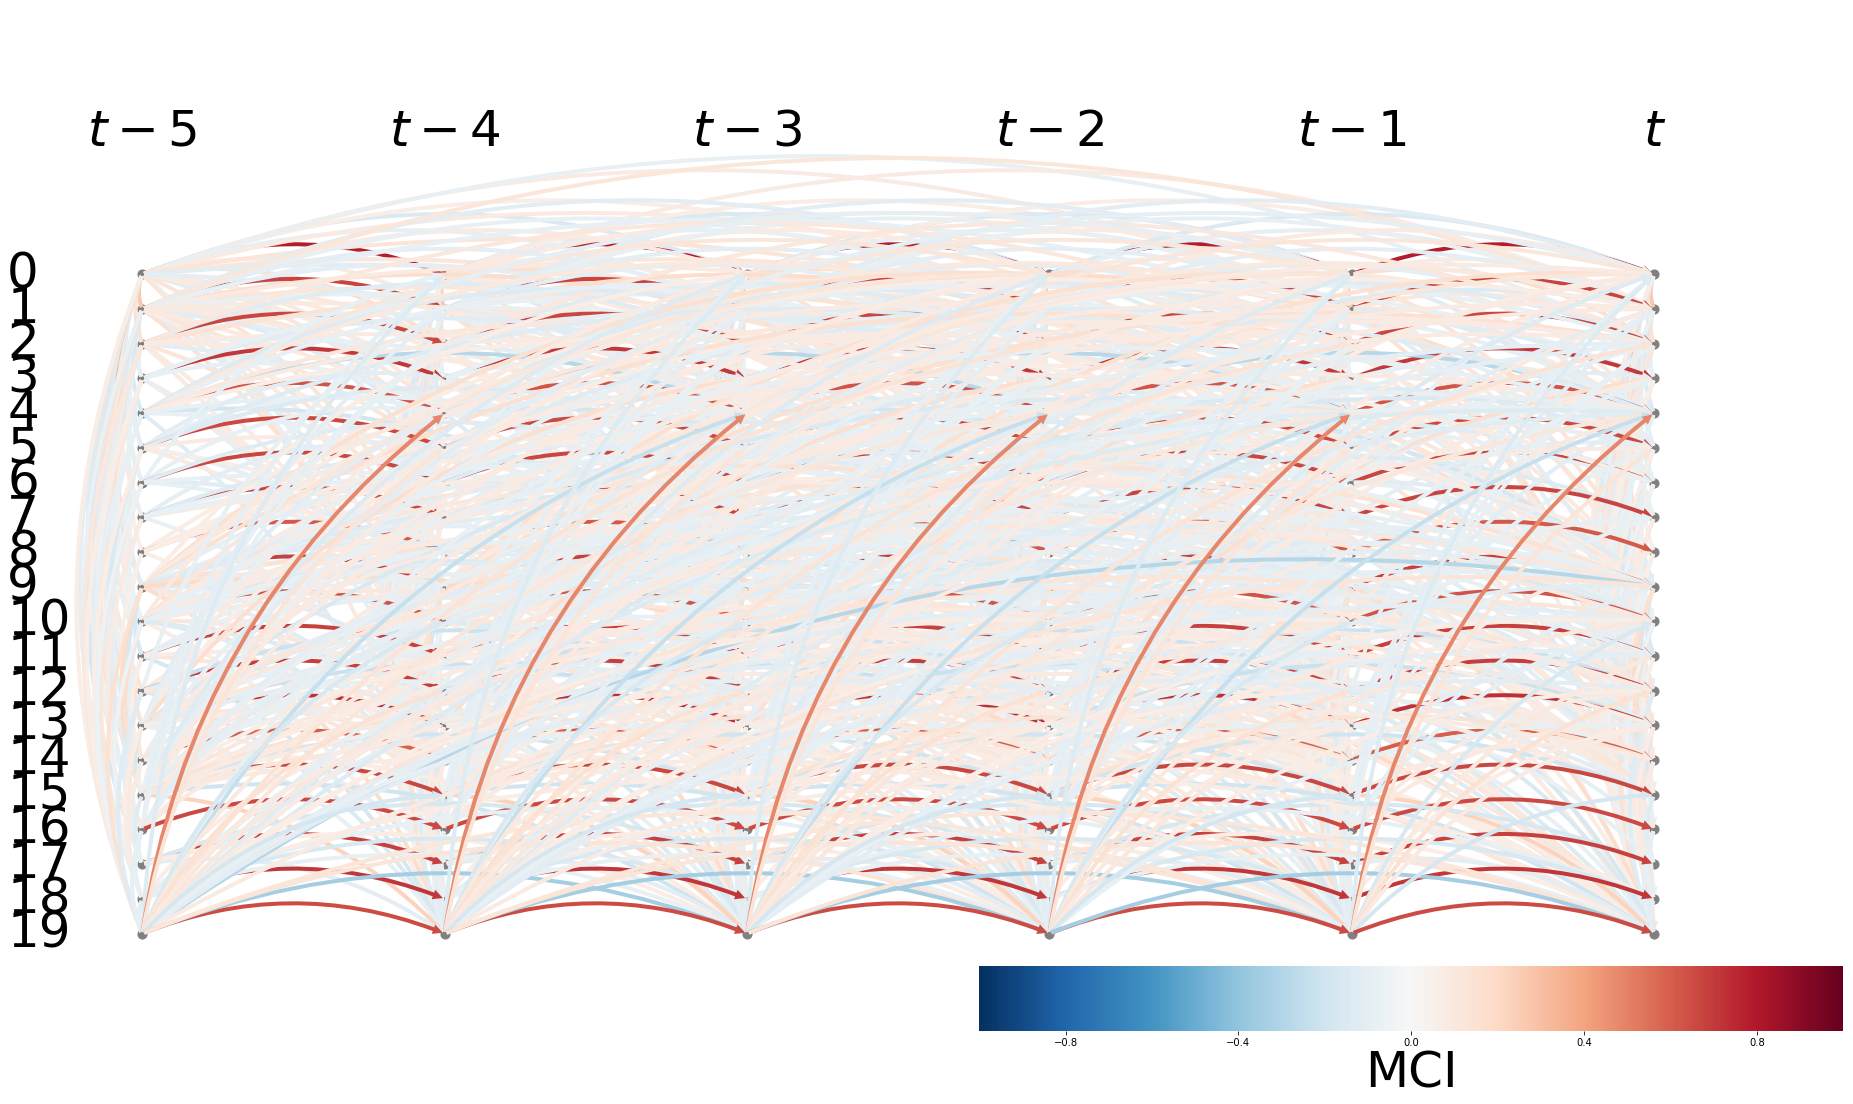

In [40]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

In [52]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [53]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [54]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 12 link(s):
        (10 0): pval = 0.00000 | val = -0.203
        (0 -1): pval = 0.00000 | val = 0.138
        (5 0): pval = 0.00000 | val = 0.119
        (12 0): pval = 0.00004 | val = 0.106
        (18 0): pval = 0.00016 | val = 0.098
        (3 0): pval = 0.00072 | val = 0.088
        (6 0): pval = 0.00121 | val = -0.084
        (12 -1): pval = 0.00921 | val = 0.068
        (1 -2): pval = 0.01725 | val = 0.062
        (13 0): pval = 0.02085 | val = 0.060
        (1 0): pval = 0.02450 | val = -0.058
        (8 -1): pval = 0.04153 | val = 0.053

    Variable 1 has 22 link(s):
        (1 -1): pval = 0.00000 | val = 0.296
        (16 0): pval = 0.00000 | val = 0.199
        (4 0): pval = 0.00000 | val = -0.185
        (9 -1): pval = 0.00001 | val = 0.114
        (5 0): pval = 0.00002 | val = -0.110
        (4 -1): pval = 0.00008 | val = 0.102
        (7 0): pval = 0.00024 | val = 0.095
        (16 -1): pval = 0.00064 | val = -0.

In [55]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 7 link(s):
        (10 0): pval = 0.00000 | qval = 0.00000 | val = -0.203
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.138
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.119
        (12 0): pval = 0.00004 | qval = 0.00004 | val = 0.106
        (18 0): pval = 0.00016 | qval = 0.00016 | val = 0.098
        (3 0): pval = 0.00072 | qval = 0.00072 | val = 0.088
        (6 0): pval = 0.00121 | qval = 0.00121 | val = -0.084

    Variable 1 has 10 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.296
        (16 0): pval = 0.00000 | qval = 0.00000 | val = 0.199
        (4 0): pval = 0.00000 | qval = 0.00000 | val = -0.185
        (9 -1): pval = 0.00001 | qval = 0.00030 | val = 0.114
        (5 0): pval = 0.00002 | qval = 0.00002 | val = -0.110
        (4 -1): pval = 0.00008 | qval = 0.00180 | val = 0.102
        (7 0): pval = 0.00024 | qval = 0.00024 | val = 0.095
        (16 -1): pval = 0.00064 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f195bcf0ba8>)

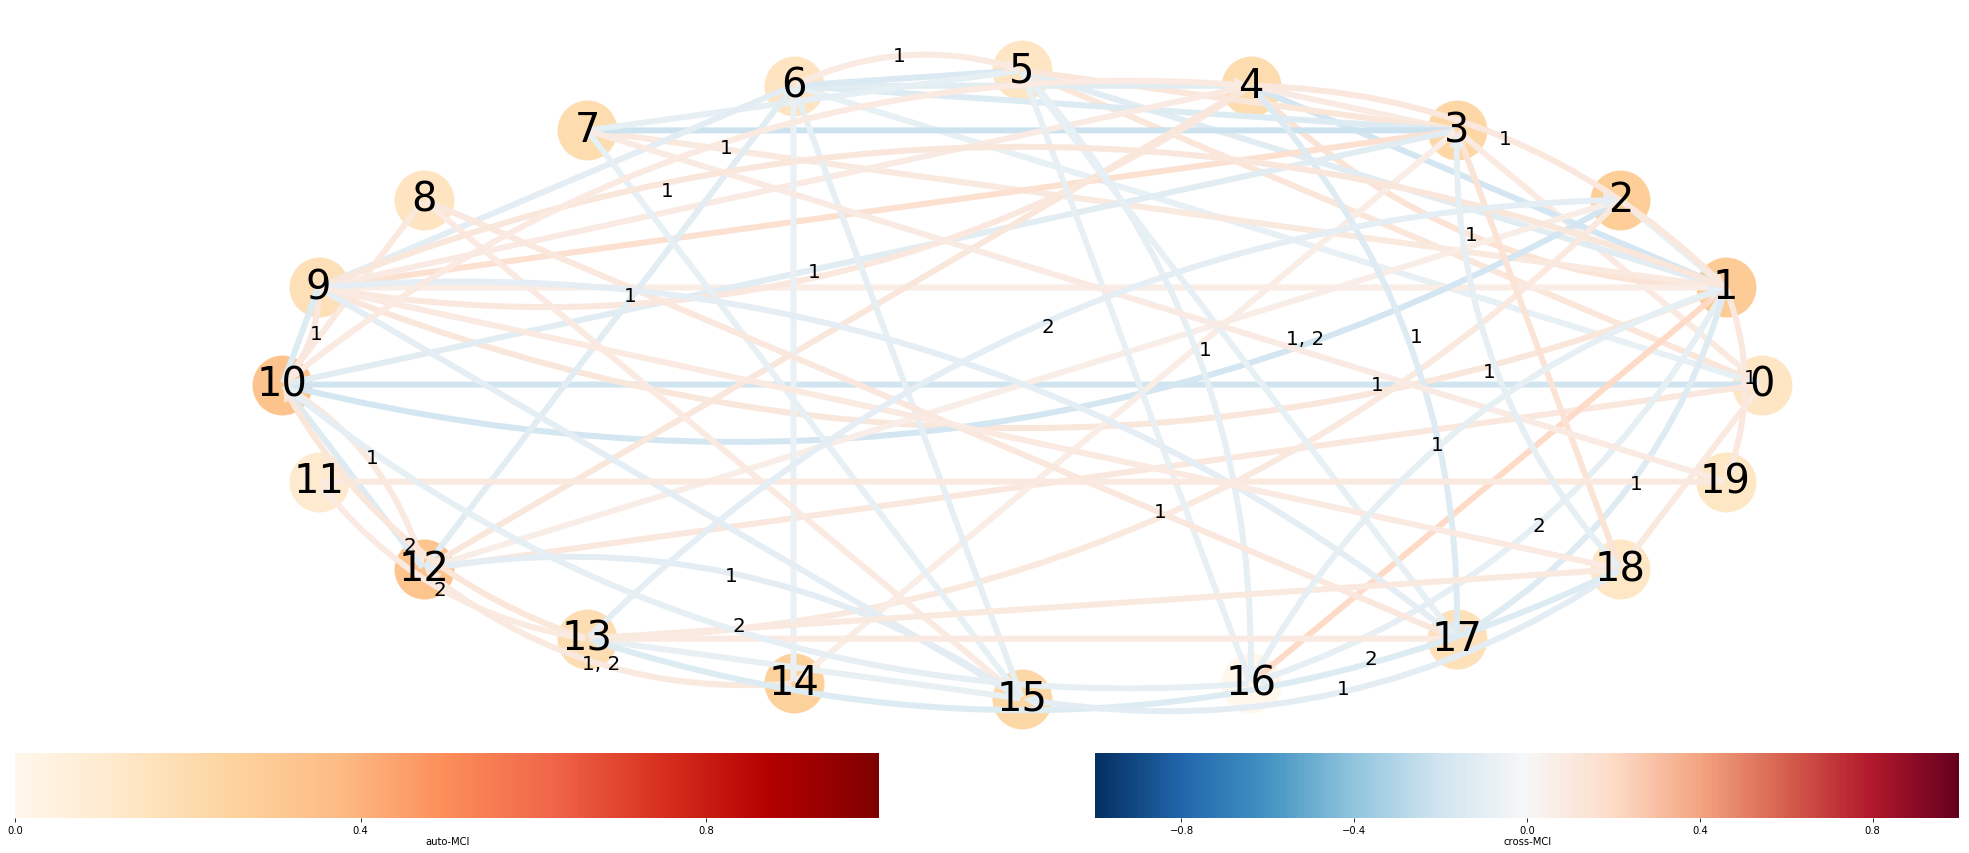

In [56]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

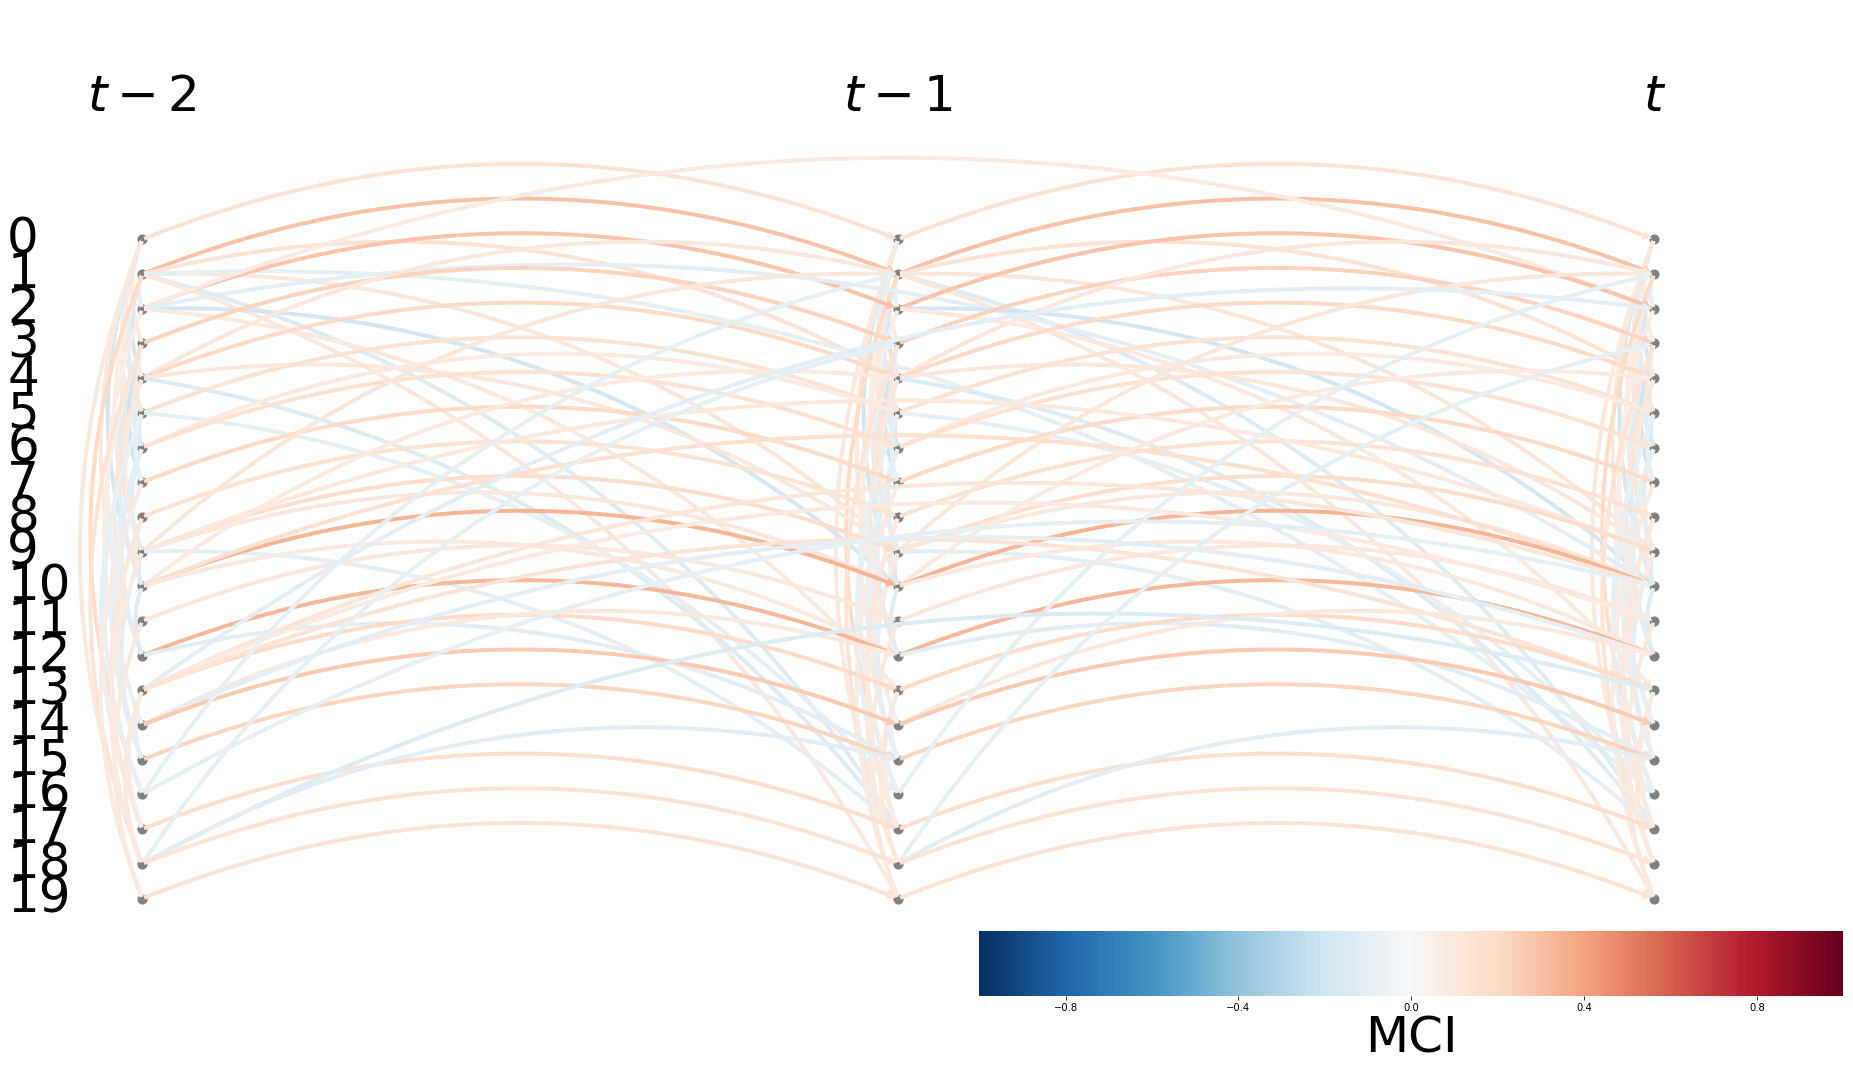

In [57]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )